# Abstract

# Data Exploration

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

# make a copy to use and view that data
df_ = df_train.copy()
df_

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10
...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,MORTGAGE,8.0,EDUCATION,A,3000,7.29,0,0.02,N,17
26060,23,48000,RENT,1.0,VENTURE,A,4325,5.42,0,0.09,N,4
26061,22,60000,RENT,0.0,MEDICAL,B,15000,11.71,0,0.25,N,4
26062,30,144000,MORTGAGE,12.0,PERSONAL,C,35000,12.68,0,0.24,N,8


Lets explore how loan intent varies across age groups

Text(0.5, 1.0, 'Loan Intent by Age')

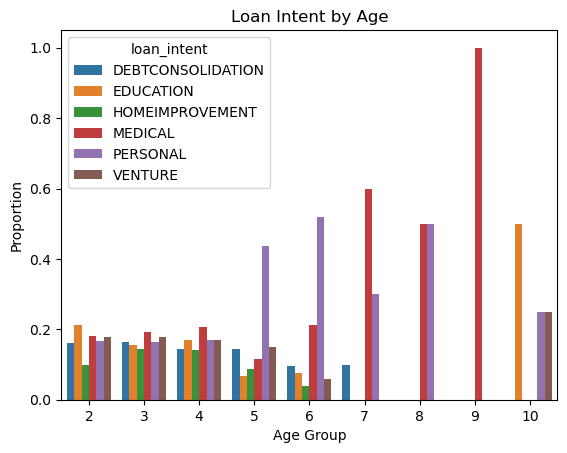

In [71]:
# first lets add a column for age groups
df_["age_group"] = df_["person_age"] // 10
df_["age_group"][df_["age_group"] >= 10 ] = 10

# Get the counts of each loan intent within each age group
loan_intent_counts = df_.groupby("age_group")["loan_intent"].value_counts().unstack()
loan_intent_counts = loan_intent_counts.fillna(0)

# Convert counts to proportions relative to each age group
loan_intent_prop = loan_intent_counts.div(loan_intent_counts.sum(axis=1), axis=0)

# visualize the trends of loan intent and age
temp = pd.melt(loan_intent_prop)

temp["age_group"] = 0 # rebuild the age group category
for i in range(0, len(temp) + 1):
  temp["age_group"][i] = (i % 9) + 2

ax = sns.barplot(data = temp, x = "age_group", y = "value", hue = "loan_intent")
ax.set_xlabel("Age Group")
ax.set_ylabel("Proportion")
ax.set_title("Loan Intent by Age")

Debt Consolidation is relatively evently represtend between laoners aged 20 - 59, dropping off in the 70 - 79 age group. Education is of course more highly represented in younger loaners, aged 20 - 39, but is also extremely high in loaners of 100+ years old. In the 100+ year old group around 50% of all loans taken out are for Education. Home Improvement is of course more common in younger loaners, aged 20 - 59. Medical loans takes up a larger proportion of loans in older loaners, with 100% of loans in 90 - 99 year olds being for medical reasons. Personal loans are most common in loaners aged 50 - 89, but are still prevalent in younger loaners. Venture is spread evenly throughout all age groups but never eclipses more than 25% of loans. An important trend to notice is that in age groups 2-4 there is a fairly even distribution of all loan intents. Now lets look at how loan size varies by length of employment. 

In [ ]:
# Visualize how loan size varies by employment length

#sns.scatterplot(data = df_train, x = "person_emp_length", y = "loan_amnt")

0         0.0
1         3.0
2         5.0
3         2.0
4         2.0
         ... 
26059     8.0
26060     1.0
26061     0.0
26062    12.0
26063     5.0
Name: person_emp_length, Length: 26064, dtype: float64